In [17]:
import pandas as pd
import numpy as np

In [18]:
from nltk.tokenize import word_tokenize 
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense
import tensorflow as tf

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/oprah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##1D - CNN


In [21]:
num_classes = 8
embed_num_dims = 300
max_seq_len = 500

class_names = ['joy','surprise','love', 'fear', 'anger', 'sadness','depression','anxiety']

In [22]:
from sklearn.model_selection import train_test_split
data= pd.read_csv('emotion_analysis.csv',encoding='latin1')
data.head()

,Message,Emotion
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [23]:
data.Emotion.unique()

array(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise', 'anxiety',
       'depression'], dtype=object)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data['Message'],data['Emotion'], test_size=0.33, random_state=42)

In [25]:
data_train = pd.DataFrame(pd.concat([X_train, y_train], axis=1))
data_test = pd.DataFrame(pd.concat([X_test, y_test], axis=1))

In [26]:
data.head()

,Message,Emotion
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [27]:
def preprocess_text(data):
  
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)
    
    return data

In [28]:

texts = [' '.join(preprocess_text(text)) for text in data.Message]

texts_train = [' '.join(preprocess_text(text)) for text in X_train]
texts_test = [' '.join(preprocess_text(text)) for text in X_test]

In [29]:
print(texts_train[29])

Tl qnjir come to make excitement


In [30]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 19496


In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
max_seq_len = 256
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,     7,  1004,  3502],
       [    0,     0,     0, ...,    15,     6,   181],
       [    0,     0,     0, ...,    37,     9,   154],
       ...,
       [    0,     0,     0, ..., 11092,  6865,   799],
       [    0,     0,     0, ...,   397,  2286,  8768],
       [    0,     0,     0, ...,   661,  1855,   335]], dtype=int32)

In [33]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'love': 4,
    'surprise': 5,
    'depression':6,
    'anxiety': 7
}

y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [34]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [35]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [36]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [37]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(19497, 300)

In [38]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 14787
New words found: 4709


In [39]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [41]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,849,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,849,100 (22.31 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,849,100 (22.31 MB)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr /= 3
    return lr

lrs = LearningRateScheduler(lr_scheduler)
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

In [69]:
batch_size = 256
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test),
                callbacks=[
                          es,
                          ModelCheckpoint('oprahsmodel.keras', monitor='val_loss', save_best_only=True, verbose=1),
                          lrs
                      ])

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.4390 - loss: 1.6338
Epoch 1: val_loss improved from inf to 1.00512, saving model to oprahsmodel.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.4413 - loss: 1.6283 - val_accuracy: 0.6912 - val_loss: 1.0051 - learning_rate: 0.0010
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7226 - loss: 0.8644
Epoch 2: val_loss improved from 1.00512 to 0.52811, saving model to oprahsmodel.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.7237 - loss: 0.8614 - val_accuracy: 0.8321 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8665 - loss: 0.4320
Epoch 3: val_loss improved from 0.52811 to 0.38115, saving model to oprahsmodel.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - accuracy: 0.8668 - loss: 0.4312 - val_accuracy: 0.8867 - val_loss: 0.3812 - learning_rate: 0.0010
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy

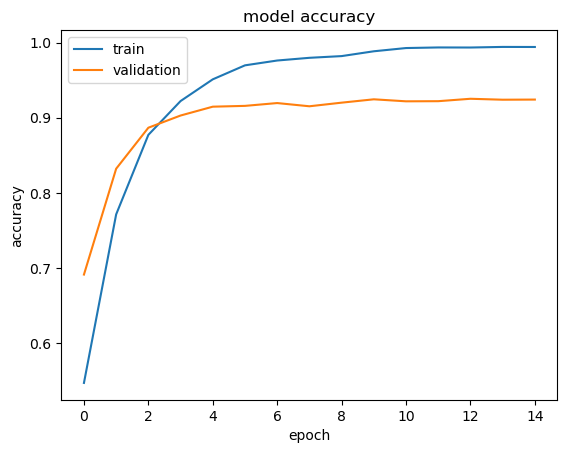

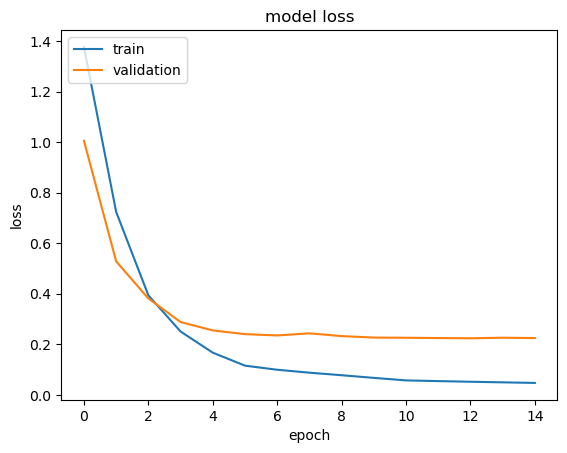

In [71]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [73]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Accuracy: 58.72%

F1 Score: 58.72


In [75]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
 
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 58.72


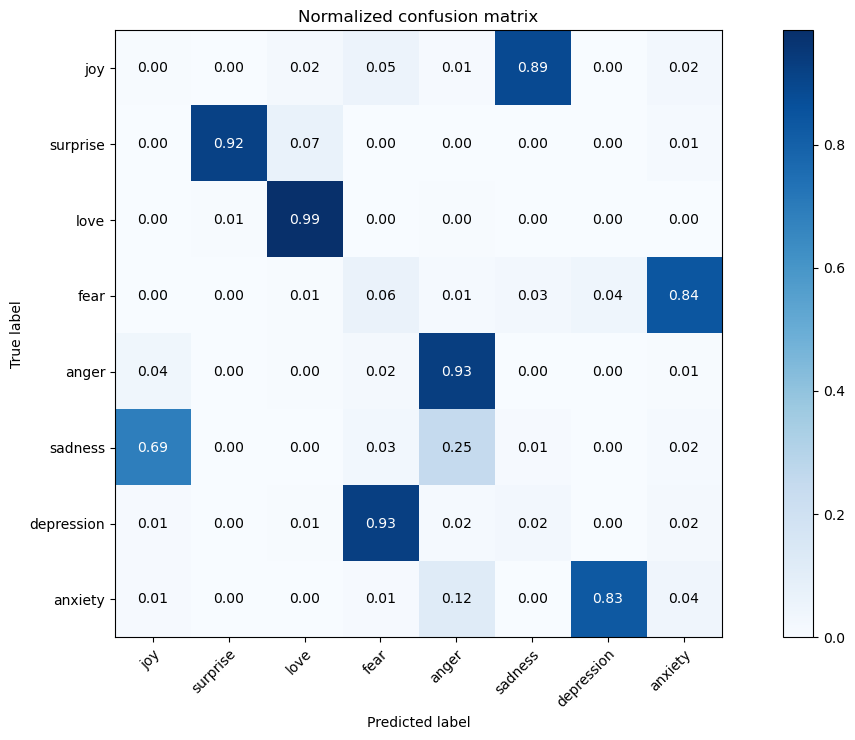

In [77]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))


plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [81]:
print('Message: {}\nPredicted: {}'.format(X_test[0], predictions[0]))

Message: i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here
Predicted: joy


In [83]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Message: ['delivery was hour late and my pizza was cold!']
predicted: depression (0.15 seconds)


In [85]:
model.save('models/cnn_oprah_cnn.h5')

## L.S.T.M

In [88]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [90]:
lstm_output_size = 128
bidirectional = True


model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(LSTM(units=lstm_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(LSTM(units=lstm_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [92]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     5,849,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,849,100 (22.31 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,849,100 (22.31 MB)

In [94]:
batch_size = 128
epochs = 20

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test) ,callbacks=[
                          es,
                          ModelCheckpoint('oprahsmodel.keras', monitor='val_loss', save_best_only=True, verbose=1),
                          lrs
                      ])

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4198 - loss: 1.6973
Epoch 1: val_loss improved from inf to 1.08497, saving model to oprahsmodel.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 48s 529ms/step - accuracy: 0.4208 - loss: 1.6945 - val_accuracy: 0.6448 - val_loss: 1.0850 - learning_rate: 0.0010
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.6510 - loss: 1.0455
Epoch 2: val_loss improved from 1.08497 to 0.87216, saving model to oprahsmodel.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 62s 696ms/step - accuracy: 0.6512 - loss: 1.0449 - val_accuracy: 0.6983 - val_loss: 0.8722 - learning_rate: 0.0010
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.7054 - loss: 0.8669
Epoch 3: val_loss improved from 0.87216 to 0.76514, saving model to oprahsmodel.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 60s 675ms/step - accuracy: 0.7055 - loss: 0.8666 - val_accuracy: 0.7392 - val_loss: 0.7651 - learning_rate: 0.0010
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy

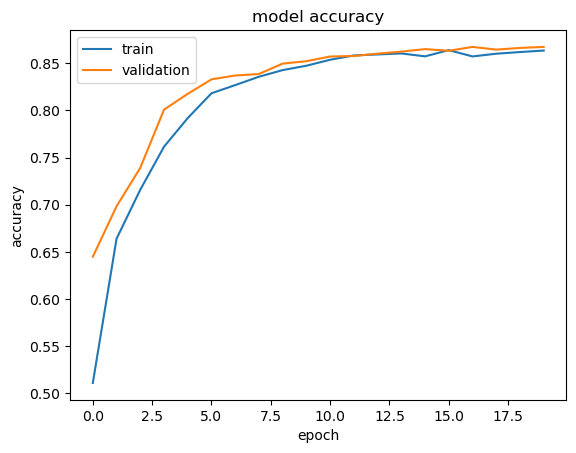

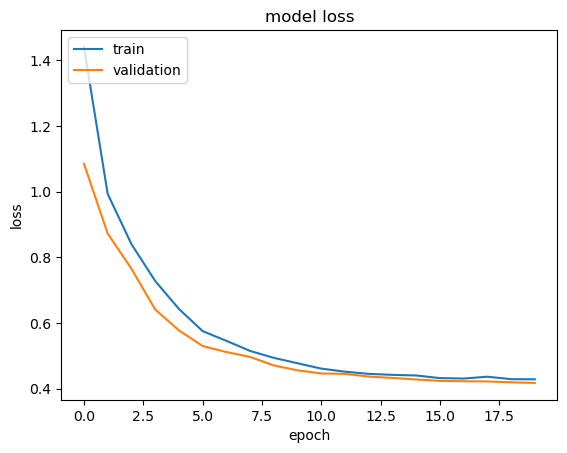

In [96]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [98]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

176/176 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step
Accuracy: 58.29%

F1 Score: 58.29



F1 Score: 58.29


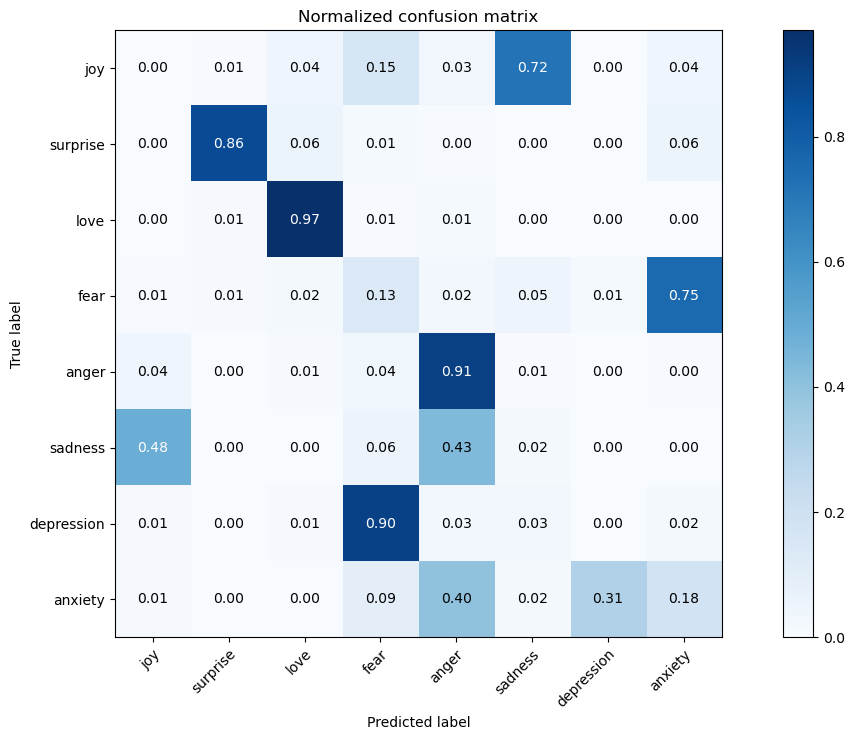

In [100]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [102]:
print('Message: {}\nPredicted: {}'.format(X_test[0], predictions[0]))

Message: i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here
Predicted: joy


In [104]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Message: ['delivery was hour late and my pizza was cold!']
predicted: depression (0.08 seconds)


In [106]:
model.save('models/lstm_oprah_lstm.h5')